# Analisi del consenso sul Bitcoin

Sei stato reclutato da un'azienda di ricerche di mercato per stimare il consenso delle persone verso il Bitcoin. Un team di data engineer ha estratto diversi milioni di tweet che parlano di Bitcoin, il tuo compito è quello di eseguire un'analisi del sentiment e creare un grafico che mostri come questo è variato giorno per giorno. Utilizza anche i dati per rispondere a domande interessanti, come:
- i tweet negativi hanno avuto più likes rispetto a quelli positivi?
- i tweet negativi hanno avuto più interazioni (risposte) rispetto a quelli positivi?

#### BONUS
Verifica se la variazione del sentiment è associata ad una variazione del valore del Bitcoin, per svolgere questa task devi reperire in autonomia lo storico di BTC USD

## Caricamento librerie

In [0]:
%sh pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [0]:
%sh pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 7.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [0]:
# Import necessary libraries for Spark and NLP
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.functions import corr

# Import TextBlob for sentiment analysis
from textblob import TextBlob

# Import Python regular expression module
import re

# Import NTLK and Download necessary NLTK datasets
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')  # Download NLTK stopwords dataset
nltk.download('wordnet')  # Download NLTK WordNet dataset
nltk.download('punkt')  # Download NLTK punkt tokenizer

# Import Pandas
import pandas as pd

# Import matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Import warning
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Caricamento e preprocessing dei tweets

1. **Inizializzazione di una SparkSession**: Si crea una SparkSession con il nome dell'applicazione "BitcoinTweets".

2. **Definizione dello schema per il DataFrame**: Si definisce lo schema per il DataFrame che verrà utilizzato per leggere i dati dal file CSV. Lo schema specifica i tipi di dati per ogni colonna, come l'ID del tweet, l'utente, il testo del tweet, il timestamp, e così via.

3. **Lettura del file CSV**: Si legge il file CSV contenente i tweet utilizzando lo schema definito e si crea un DataFrame.

4. **Rimozione delle colonne inutili**: Si eliminano le colonne "user", "fullname" e "url" poiché non sono necessarie per l'analisi successiva.

5. **Filtraggio dei dati nulli e duplicati**: Si rimuovono le righe con valori nulli nei campi 'timestamp' e 'text' e si eliminano i duplicati basati su queste colonne.

6. **Pulizia del testo dei tweet**: 
   - Si definisce una funzione per pulire il testo dei tweet, che include la conversione del testo in minuscolo, la rimozione di URL, menzioni, hashtag e caratteri non alfabetici.
   - La funzione viene registrata come UDF (User Defined Function) e applicata al DataFrame per creare una nuova colonna "cleaned_text".

7. **Filtraggio dei testi puliti**: Si rimuovono le righe dove "cleaned_text" è null o vuoto.

8. **Tokenizzazione del testo**: Si crea un array di parole dalla colonna "cleaned_text".

9. **Rimozione delle stopwords**: 
   - Si preparano le stopwords (parole comuni che vengono rimosse durante la pulizia del testo) utilizzando la libreria NLTK.
   - Si utilizza `StopWordsRemover` per rimuovere queste stopwords dall'array di parole.

10. **Lemmatizzazione**: 
    - Si inizializza un lemmatizzatore.
    - Si definisce una funzione per tokenizzare e lemmatizzare le parole, quindi si registra questa funzione come UDF e la si applica al DataFrame per creare una nuova colonna "lemmatized_text".

11. **Esportazione dei dati puliti**: 
    - Si selezionano le colonne finali di interesse ("id", "timestamp", "replies", "likes", "retweets", "lemmatized_text").
    - Si scrive il DataFrame pulito in un nuovo file CSV.

In [0]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("BitcoinTweets") \
    .getOrCreate()

# Define the schema for the DataFrame
schema = T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("user", T.StringType(), True),
    T.StructField("fullname", T.StringType(), True),
    T.StructField("url", T.StringType(), True),
    T.StructField("timestamp", T.TimestampType(), True),
    T.StructField("replies", T.FloatType(), True),
    T.StructField("likes", T.FloatType(), True),
    T.StructField("retweets", T.FloatType(), True),
    T.StructField("text", T.StringType(), True)
])

# Read the CSV file into a DataFrame using the defined schema
df = spark.read \
        .option("header", "true") \
        .option("multiLine", "true") \
        .schema(schema) \
        .csv("/FileStore/tables/bitcoin_tweets.csv")

# Remove unnecessary columns from the DataFrame
columns_to_drop = ["user", "fullname", "url"]
df = df.drop(*columns_to_drop)

# Filter out rows with null 'timestamp' or 'text' and remove duplicate rows based on these columns
df = df.dropna(subset=['timestamp', 'text']).dropDuplicates(['timestamp', 'text'])

# Define a function to clean the text data
def clean_text(text):
    if text:
        text = text.lower().strip()  # Convert to lowercase and strip whitespace
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
        return text.strip()
    else:
        return None

# Register the cleaning function as a UDF (User Defined Function)
clean_text_udf = F.udf(clean_text, T.StringType())
df = df.withColumn("cleaned_text", clean_text_udf(F.col("text")))

# Remove rows where 'cleaned_text' is null and filter out rows where 'cleaned_text' is empty
df = df.dropna(subset=["cleaned_text"]).filter(F.col("cleaned_text") != "")

# Create an array of words from the 'cleaned_text'
df = df.withColumn("cleaned_text_array", F.split(F.col("cleaned_text"), " "))

# Prepare NLTK stopwords for use in Spark
nltk_stopwords = set(stopwords.words('english'))

# Configure the StopWordsRemover to remove stopwords from 'cleaned_text_array'
remover = StopWordsRemover(inputCol="cleaned_text_array", outputCol="filtered_text", stopWords=list(nltk_stopwords))

# Apply the StopWordsRemover transformation to the DataFrame
df = remover.transform(df)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function for tokenization and lemmatization
def tokenize_and_lemmatize(text_array):
    if text_array:
        tokens = [lemmatizer.lemmatize(token) for token in text_array]
        lemmatized_text = ' '.join(tokens)  # Convert array back to string
        lemmatized_text = re.sub(r'\s+', ' ', lemmatized_text)  # Remove extra spaces
        return lemmatized_text.strip()
    else:
        return None

# Register the lemmatization function as a UDF
tokenize_and_lemmatize_udf = F.udf(tokenize_and_lemmatize, T.StringType())

# Apply the lemmatization transformation to the DataFrame
df = df.withColumn("lemmatized_text", tokenize_and_lemmatize_udf(F.col("filtered_text")))

# Define the output path for the cleaned data
output_path = "/FileStore/tables/cleaned_bitcoin_tweets.csv"

# Select specific columns for the final output
selected_columns = ["id", "timestamp", "replies", "likes", "retweets", "lemmatized_text"]

# Write the cleaned DataFrame to a new CSV file
df.select(selected_columns) \
    .write \
    .mode("overwrite") \
    .csv(output_path, header=True)

Salvare un DataFrame pulito dopo la pulizia su Apache Spark offre numerosi vantaggi, specialmente quando si lavora con grandi dataset e si pianificano ulteriori analisi. Di seguito sono elencati i principali motivi:

1. **Efficienza**: Dopo aver eseguito le operazioni di pulizia (come la rimozione di valori nulli, duplicati, stopwords e applicazione della lemmatizzazione), il dataset risultante è più compatto e strutturato. Salvare questa versione pulita riduce il carico computazionale per le analisi future, evitando di dover ripetere le stesse operazioni di pulizia.

2. **Riproducibilità**: Salvando il dataset pulito, si può garantire che le analisi future partano sempre dalla stessa base di dati, riducendo il rischio di errori e discrepanze nei risultati.

3. **Sicurezza**: Il dataset grezzo può contenere dati sensibili o ridondanti che non sono necessari per l'analisi. Salvando solo i dati puliti, si riduce l'esposizione di informazioni non necessarie.

4. **Scalabilità**: Spark è progettato per gestire grandi quantità di dati in modo distribuito. Una volta puliti e salvati, i dati possono essere facilmente caricati e analizzati su diversi cluster Spark, migliorando la scalabilità delle operazioni.

5. **Performance**: La versione pulita del dataset è generalmente più piccola e ottimizzata, il che si traduce in tempi di caricamento e analisi più rapidi. Questo è particolarmente utile quando si eseguono analisi iterative o si sviluppano modelli di machine learning.

6. **Consistenza**: Salvando il dataset pulito, si può assicurare che tutte le parti dell'organizzazione che utilizzano questi dati lavorino con informazioni consistenti e aggiornate, migliorando la collaborazione e l'affidabilità delle decisioni basate sui dati.

## Caricamento del DataFrame dei tweets pulito

1. **Definizione dello schema per il DataFrame**: Si definisce uno schema per il DataFrame che verrà utilizzato per leggere i dati dal file CSV. 

   Lo schema specifica i tipi di dati per ogni colonna:
   - `id`: Tipo stringa (StringType)
   - `timestamp`: Tipo timestamp (TimestampType)
   - `replies`: Tipo float (FloatType)
   - `likes`: Tipo float (FloatType)
   - `retweets`: Tipo float (FloatType)
   - `lemmatized_text`: Tipo stringa (StringType)

2. **Lettura del file CSV**: Si legge il file CSV contenente i tweet puliti utilizzando lo schema definito e si crea un DataFrame. 
   
   Le opzioni specificate includono:
   - `header`: Indica che il file CSV contiene una riga di intestazione (`true`).
   - `multiLine`: Indica che i campi del CSV possono estendersi su più linee (`true`).

3. **Visualizzazione del DataFrame**: Si visualizza il dataframe per essere sicuri di avere a disposizione i dati necessari per le successive analisi.

In [0]:
# Define the schema for the DataFrame
schema = T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("timestamp", T.TimestampType(), True),
    T.StructField("replies", T.FloatType(), True),
    T.StructField("likes", T.FloatType(), True),
    T.StructField("retweets", T.FloatType(), True),
    T.StructField("lemmatized_text", T.StringType(), True)
])

# Read the CSV file into a DataFrame using the defined schema
df = spark.read \
        .option("header", "true") \
        .option("multiLine", "true") \
        .schema(schema) \
        .csv("/FileStore/tables/cleaned_bitcoin_tweets.csv")

In [0]:
display(df.limit(100))

id,timestamp,replies,likes,retweets,lemmatized_text
1110302988,2009-01-11T03:33:52Z,790.0,14470.0,5542.0,running bitcoin
23945637082955776,2011-01-09T02:34:19Z,2.0,39.0,18.0,btc usd size btc last h btc k trx difficulty k forum postsday node k
71069707205214209,2011-05-19T02:28:33Z,0.0,3.0,3.0,converted k linden bitcoins think like per bitcoin pretty interesting
72782678402936832,2011-05-23T21:55:17Z,60.0,907.0,245.0,invest life saving bitcoin
153274506411122688,2011-12-31T23:41:04Z,0.0,0.0,0.0,sun jan traded btc usdbtc
153275493356011520,2011-12-31T23:44:59Z,0.0,0.0,0.0,sun jan traded btc usdbtc
153275513341870080,2011-12-31T23:45:04Z,0.0,0.0,0.0,sun jan traded btc usdbtc
153279076872884224,2011-12-31T23:59:14Z,0.0,0.0,0.0,sun jan traded btc usdbtc
153279752856272896,2012-01-01T00:01:55Z,0.0,0.0,0.0,sun jan traded btc usdbtc
153627159364251648,2012-01-01T23:02:23Z,0.0,0.0,0.0,mon jan traded btc usdbtc


## Analisi del Sentiment sui tweets

1. **Definizione della funzione per calcolare il sentimento**: 
   - La funzione `analyze_sentiment` prende in input un testo.
   - Viene creato un oggetto TextBlob per il testo in input.
   - Si determina la polarità del testo e si ritorna il corrispondente sentimento:
     - `positive` se la polarità è maggiore di 0.
     - `negative` se la polarità è minore di 0.
     - `neutral` se la polarità è uguale a 0.

2. **Registrazione della funzione definita dall'utente (UDF)**: 
   - La funzione `analyze_sentiment` viene registrata come una UDF (User-Defined Function) per poter essere utilizzata con i DataFrame di Spark.

3. **Applicazione della UDF al DataFrame**: 
   - Si applica la UDF al DataFrame per creare una nuova colonna "sentiment" contenente il risultato dell'analisi del sentimento per ogni riga.

4. **Filtro le righe nulle**: 
   - Si fltrano le righe che hanno `lemmatized_text` nullo.

5. **Creazione di una colonna di data combinata**:
   - Viene creata una nuova colonna `date` nel formato `"yyyy-MM-dd"` a partire dalla colonna `"timestamp"`.   

6. **Visualizzazione del DataFrame aggiornato**: 
   - Si mostra il DataFrame aggiornato con la nuova colonna "sentiment".

In [0]:
# Function to calculate sentiment
def analyze_sentiment(text):
    # Calculate polarity of the text
    polarity = TextBlob(text).sentiment.polarity
    
    # Determine sentiment based on polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Register the User-Defined Function (UDF)
sentiment_udf = F.udf(analyze_sentiment, F.StringType())

# Apply the UDF to the DataFrame
df = df.withColumn("sentiment", sentiment_udf(df["lemmatized_text"]))

# Filter out rows where lemmatized_text is null
df = df.filter(F.col("lemmatized_text").isNotNull())

# Create a combined date column in the format yyyy-MM-dd
df = df.withColumn("date", F.date_format("timestamp", "yyyy-MM-dd"))

# Show the updated DataFrame with the new sentiment column
df.show()

+------------------+-------------------+-------+-------+--------+--------------------+---------+----------+
|                id|          timestamp|replies|  likes|retweets|     lemmatized_text|sentiment|      date|
+------------------+-------------------+-------+-------+--------+--------------------+---------+----------+
|        1110302988|2009-01-11 03:33:52|  790.0|14470.0|  5542.0|     running bitcoin|  neutral|2009-01-11|
| 23945637082955776|2011-01-09 02:34:19|    2.0|   39.0|    18.0|btc usd size btc ...|  neutral|2011-01-09|
| 71069707205214209|2011-05-19 02:28:33|    0.0|    3.0|     3.0|converted k linde...| positive|2011-05-19|
| 72782678402936832|2011-05-23 21:55:17|   60.0|  907.0|   245.0|invest life savin...|  neutral|2011-05-23|
|153274506411122688|2011-12-31 23:41:04|    0.0|    0.0|     0.0|sun jan traded bt...|  neutral|2011-12-31|
|153275493356011520|2011-12-31 23:44:59|    0.0|    0.0|     0.0|sun jan traded bt...|  neutral|2011-12-31|
|153275513341870080|2011-12-

## Analisi dei dati dei tweets giorno per giorno in base al sentiment

1. **Raggruppamento per la nuova colonna di data combinata e sentimento**:
   - Il DataFrame è raggruppato per le colonne `date` e `sentiment`.
   - Viene calcolato il conteggio dei sentimenti per ogni combinazione di data e sentiment.
   - I risultati sono ordinati per `date`.

2. **Visualizzazione dei risultati**:
   - Mostra il DataFrame risultante con il conteggio dei sentiment per data e tipo di sentiment, fornendo una panoramica dettagliata sull'andamento dei sentiment nel tempo.

In [0]:
# Group by the new combined date column and sentiment, and calculate sentiment counts
daily_sentiment = df.groupBy("date", "sentiment").count().orderBy("date")

# Show the result
daily_sentiment.show()

+----------+---------+-----+
|      date|sentiment|count|
+----------+---------+-----+
|2009-01-11|  neutral|    1|
|2011-01-09|  neutral|    1|
|2011-03-27| positive|    1|
|2011-04-14| positive|    1|
|2011-04-24|  neutral|    1|
|2011-05-10| positive|    1|
|2011-05-11|  neutral|    1|
|2011-05-14|  neutral|    1|
|2011-05-15| positive|    1|
|2011-05-16| positive|    3|
|2011-05-16|  neutral|    2|
|2011-05-16| negative|    1|
|2011-05-17| positive|    1|
|2011-05-18| positive|    1|
|2011-05-19| positive|    2|
|2011-05-19| negative|    2|
|2011-05-19|  neutral|    1|
|2011-05-20| positive|    1|
|2011-05-20|  neutral|    1|
|2011-05-23|  neutral|    1|
+----------+---------+-----+
only showing top 20 rows



## Creazione di un Grafico della Variazione del Sentiment dei Tweet su Bitcoin

#### Definizione della Palette di Colori Personalizzata
Viene definito un dizionario `custom_colors` che mappa le categorie di sentiment a colori specifici:
- `'neutral'`: Grigio
- `'positive'`: Verde
- `'negative'`: Rosso

#### Generazione della Palette di Colori
Viene utilizzata una list comprehension per generare una lista di colori `palette`. Questa lista è basata sui valori unici di sentiment nella colonna `'sentiment'` del DataFrame `pdf`, utilizzando la palette definita in precedenza.

#### Creazione del Grafico
1. **Dimensioni del Grafico**: Viene creato un nuovo grafico con dimensioni specificate di 14 pollici di larghezza per 7 pollici di altezza.
   
2. **Plot dei Dati**: Utilizzando Seaborn (`sns.lineplot`), vengono visualizzati i dati:
   - sull'asse x (`"date"`): La data dei tweet.
   - sull'asse y (`"count"`): Il conteggio dei tweet.
   - Il colore delle linee è basato sul valore della colonna `"sentiment"` utilizzando la palette personalizzata.

3. **Titolo, Etichette degli Assi e Legenda**:
   - **Titolo**: "Variazione del Sentiment dei Tweet su Bitcoin Giorno per Giorno".
   - **Etichetta sull'Asse x**: "Data".
   - **Etichetta sull'Asse y**: "Conteggio dei Tweet".
   - **Legenda**: Viene aggiunta una legenda con titolo personalizzato ("Sentiment") e etichette per i sentimenti ("Neutral", "Positive", "Negative").

4. **Visualizzazione del Grafico**: Il grafico viene mostrato utilizzando `plt.show()`.

Questo codice è ideale per esplorare e visualizzare in modo efficace come il sentiment nei tweet su Bitcoin varia nel tempo, utilizzando una palette di colori che aiuta a distinguere chiaramente i diversi tipi di sentimenti espressi.

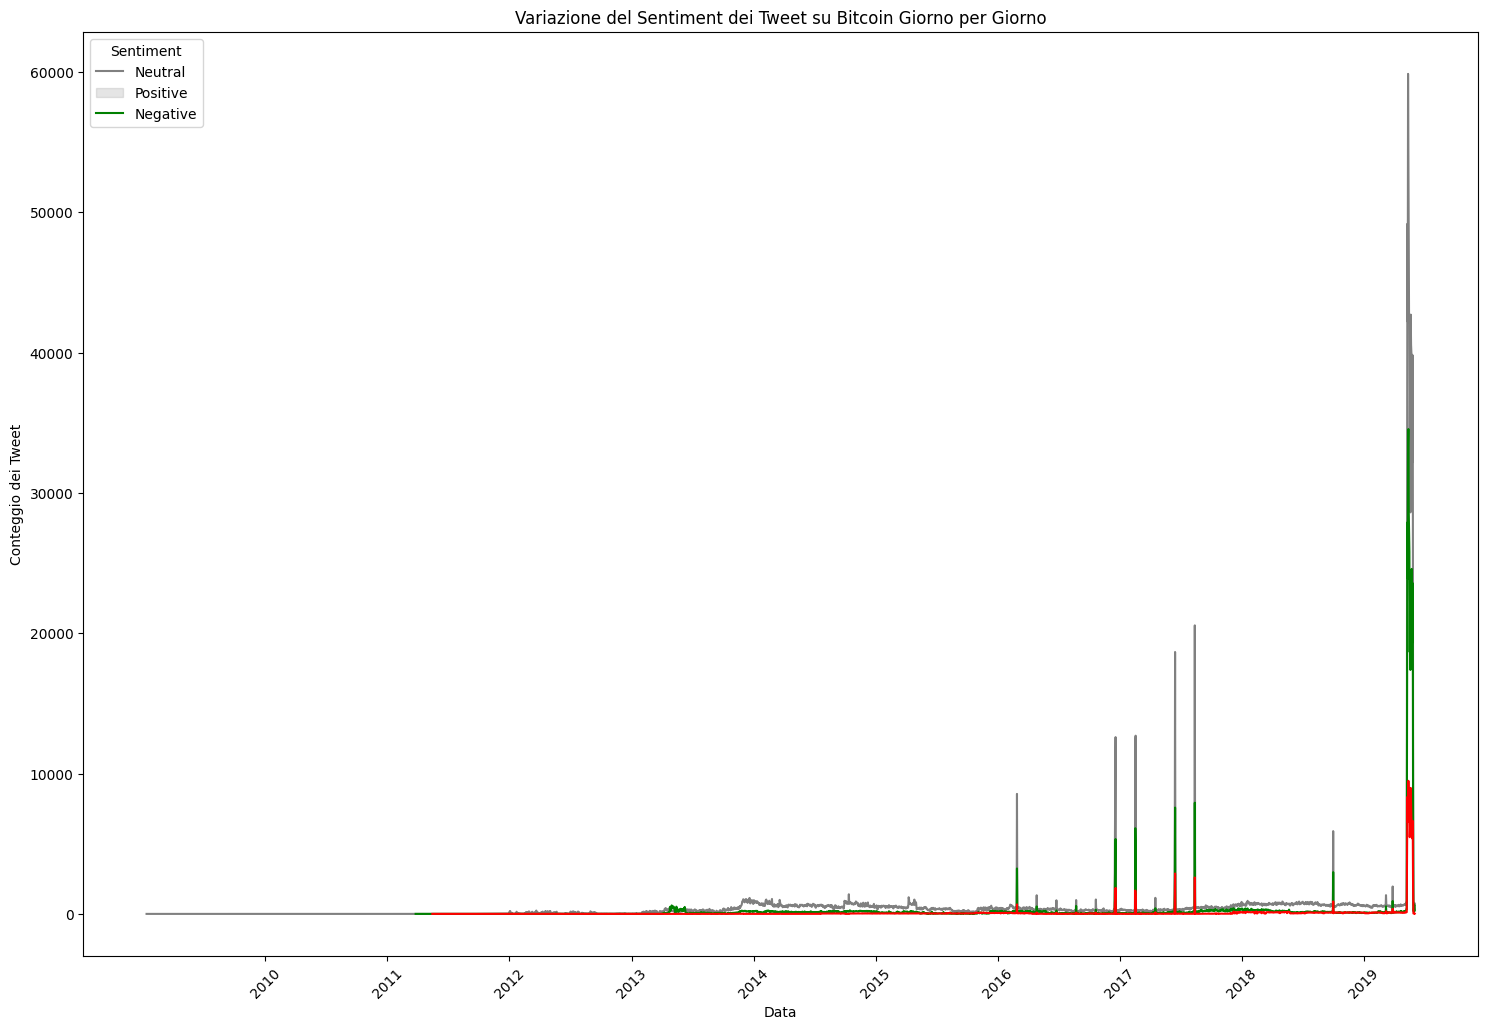

In [0]:
# Convert Spark DataFrame to Pandas DataFrame
pdf = daily_sentiment.toPandas()

# Ensure 'date' column is datetime and set it as index
pdf['date'] = pd.to_datetime(pdf['date'])
pdf.set_index('date', inplace=True)

# Raggruppa per mese e calcola la media del conteggio dei tweet
pdf_monthly = pdf.resample('M').mean().reset_index()

# Create a custom color palette
custom_colors = {'neutral': 'gray', 'positive': 'green', 'negative': 'red'}

# Generate a palette of colors based on unique sentiment values
palette = [custom_colors[sentiment] for sentiment in pdf['sentiment'].unique()]

# Create a new figure for the plot with specified size
plt.figure(figsize=(18, 12))

# Generate a line plot using Seaborn
sns.lineplot(data=pdf, x="date", y="count", hue="sentiment", palette=palette)

# Set the X-axis format to display only years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(pd.date_range(pdf.index.min(), pdf.index.max(), freq='YS'), rotation=45)

# Set the title, xlabel, and ylabel of the plot
plt.title('Variazione del Sentiment dei Tweet su Bitcoin Giorno per Giorno')
plt.xlabel('Data')
plt.ylabel('Conteggio dei Tweet')

# Add a legend with custom title and labels
plt.legend(title='Sentiment', labels=['Neutral', 'Positive', 'Negative'])

# Display the plot
plt.show()


## Analisi dei like e delle interazioni sui tweets

#### Raggruppamento del DataFrame per la Colonna "sentiment"
Il DataFrame `df` è stato raggruppato per la colonna `"sentiment"` per calcolare le medie dei campi `"likes"` e `"replies"`.

#### Calcolo delle Medie
Utilizzando il metodo `.groupBy()` e `.agg()`, vengono calcolate le seguenti medie:
- **`avg_likes`**: Media dei "likes" per ogni categoria di sentimento.
- **`avg_replies`**: Media delle "replies" per ogni categoria di sentimento.

#### Visualizzazione del DataFrame Risultante
Il DataFrame risultante, `likes_interactions`, contiene le medie dei "likes" e delle "replies" per ciascuna categoria di sentimento.

#### Mostrare il DataFrame Risultante
Viene mostrato il DataFrame `likes_interactions` che presenta le medie dei "likes" e delle "replies" per ogni categoria di sentimento, fornendo una panoramica delle interazioni medie associate a ciascun tipo di sentiment.

In [0]:
# Group the DataFrame by the "sentiment" column and compute averages and standard deviations
interactions_stats = df.groupBy("sentiment").agg(
    F.avg("likes").alias("avg_likes"),
    F.stddev("likes").alias("stddev_likes"),  # Standard deviation of likes
    F.avg("replies").alias("avg_replies"),
    F.stddev("replies").alias("stddev_replies")  # Standard deviation of replies
)

# Display the resulting DataFrame containing averages and standard deviations
interactions_stats.show()

+---------+------------------+------------------+-------------------+------------------+
|sentiment|         avg_likes|      stddev_likes|        avg_replies|    stddev_replies|
+---------+------------------+------------------+-------------------+------------------+
| positive|3.1429044872204703| 89.15948375067475|0.39628089522599197|15.226817539784722|
|  neutral| 1.461252423637262|215.44744903590538|0.13545693087599697|6.7511132938124465|
| negative|3.6142996540406283|137.74554561989765|0.43382861704958753|12.146831757870578|
+---------+------------------+------------------+-------------------+------------------+



#### I tweet negativi hanno avuto più likes rispetto a quelli positivi?

I tweet negativi hanno mostrato una media leggermente superiore di likes rispetto ai tweet positivi. Tuttavia, è importante notare che la deviazione standard per i likes dei tweet negativi è significativamente più alta rispetto a quella dei tweet positivi. Ciò indica che, sebbene i tweet negativi abbiano ottenuto in media più likes, c'è anche una maggiore variabilità nei risultati dei likes per questi tweet rispetto ai tweet positivi.


#### I tweet negativi hanno avuto più interazioni (risposte) rispetto a quelli positivi?

I tweet negativi hanno mostrato una media leggermente superiore di risposte rispetto ai tweet positivi. Tuttavia, la differenza è minima. La deviazione standard delle risposte per i tweet negativi è inferiore rispetto a quella dei tweet positivi, indicando che le risposte ai tweet negativi sono meno variabili rispetto ai tweet positivi.


## Caricamento dati che rappresentano il valore del Bitcoin nel tempo

#### Definizione dello Schema
Viene definito uno schema `price_schema` per il DataFrame dei prezzi:
- **`timestamp`**: Campo di tipo `TimestampType`, che rappresenta il timestamp dei dati.
- **`price`**: Campo di tipo `FloatType`, che rappresenta il valore del prezzo.

#### Lettura del File CSV con lo Schema Definito
Il file CSV contenente i dati dei prezzi viene letto in un DataFrame chiamato `price_df`, utilizzando lo schema definito (`price_schema`):
- Opzioni aggiuntive specificate includono:
  - `"header": "true"`: Indica che la prima riga contiene i nomi delle colonne.
  - `"multiLine": "true"`: Per gestire il caso in cui un campo di testo possa contenere caratteri di nuova linea.

#### Visualizzazione dei Dati
Viene mostrato il DataFrame `price_df` per verificare che i dati siano stati correttamente letti e strutturati secondo lo schema definito.

In [0]:
# Define the schema for the Price DataFrame
price_schema = T.StructType([
    T.StructField("timestamp", T.TimestampType(), True),
    T.StructField("price", T.FloatType(), True)
])

# Read the CSV file into a Price DataFrame using the defined schema
price_df = spark.read \
        .option("header", "true") \
        .option("multiLine", "true") \
        .schema(price_schema) \
        .csv("/FileStore/tables/btc_usd.csv")

# Apply the transformation to keep only the date
price_df = price_df.withColumn("date", F.date_format("timestamp", "yyyy-MM-dd")).drop("timestamp")        

# Display the DataFrame
price_df.show()

+-----+----------+
|price|      date|
+-----+----------+
| 0.09|2010-07-18|
| 0.08|2010-07-19|
| 0.07|2010-07-20|
| 0.08|2010-07-21|
| 0.05|2010-07-22|
| 0.06|2010-07-23|
| 0.05|2010-07-24|
| 0.05|2010-07-25|
| 0.06|2010-07-26|
| 0.06|2010-07-27|
| 0.06|2010-07-28|
| 0.07|2010-07-29|
| 0.06|2010-07-30|
| 0.07|2010-07-31|
| 0.06|2010-08-01|
| 0.06|2010-08-02|
| 0.06|2010-08-03|
| 0.06|2010-08-04|
| 0.06|2010-08-05|
| 0.06|2010-08-06|
+-----+----------+
only showing top 20 rows



## Associazione del sentiments dei tweets con il valore del Bitcoin

#### Unione dei DataFrame
Il DataFrame `daily_sentiment` contenente i dati di sentiment giornalieri e il DataFrame `price_df` contenente i dati storici dei prezzi del Bitcoin vengono uniti nel DataFrame `joined_df`.
- **Tipo di Join**: Viene utilizzato un inner join (`how="inner"`) basato sulla colonna `"date"`, mantenendo solo le voci che corrispondono in entrambi i DataFrame.

#### Visualizzazione del DataFrame Uniti
Viene mostrato il DataFrame `joined_df` per verificare che i dati siano stati uniti correttamente e per esplorare le relazioni tra i dati di sentiment e i prezzi storici del Bitcoin.

#### Calcolo della Correlazione
Il DataFrame `joined_df` viene successivamente raggruppato per la colonna `"sentiment"`.
- Viene calcolato il coefficiente di correlazione tra il conteggio del sentiment giornaliero e il valore del prezzo del Bitcoin utilizzando la funzione `corr()` di Spark.
- Il risultato viene rinominato come `"correlation"` e memorizzato nel DataFrame `correlation_df`.

#### Visualizzazione della Correlazione
Viene mostrato il DataFrame `correlation_df` per esaminare la correlazione tra il sentiment giornaliero e il valore del prezzo del Bitcoin per ciascuna categoria di sentiment.

Questo codice fornisce un'analisi quantitativa delle relazioni tra il sentiment espresso nei tweet e il valore del Bitcoin, evidenziando come i sentimenti influenzano potenzialmente il mercato criptovalutario.

In [0]:
# Merge historical Bitcoin price data with daily sentiment data.
# This operation joins the daily_sentiment DataFrame with price_df based on the "timestamp" column,
# using an inner join to retain only matching entries.
joined_df = daily_sentiment.join(price_df, on="date", how="inner")
joined_df.show()

# Calculate the correlation between sentiment and Bitcoin price value.
# Group the joined DataFrame by the "sentiment" column and compute the correlation coefficient
# between the daily sentiment count and the Bitcoin price.
correlation_df = joined_df.groupBy("sentiment").agg(
    corr("count", "price").alias("correlation")
)
correlation_df.show()

+----------+---------+-----+------+
|      date|sentiment|count| price|
+----------+---------+-----+------+
|2012-11-29| positive|    3| 12.45|
|2013-09-24| positive|   43|122.54|
|2014-03-23| positive|  134|561.35|
|2014-06-15| positive|  120|591.97|
|2014-08-23| negative|   26|497.22|
|2014-11-12|  neutral|  684|427.24|
|2014-12-15|  neutral|  476| 345.1|
|2015-02-14|  neutral|  497|257.47|
|2015-06-03| negative|   30|225.65|
|2015-08-10| negative|   60|263.76|
|2015-09-13| negative|   32|230.33|
|2016-02-22|  neutral|  459|438.07|
|2016-02-29|  neutral|  457|436.61|
|2016-03-11| positive|  206|419.89|
|2016-03-12| positive|  175|410.13|
|2016-04-24| positive|   77|460.33|
|2016-05-19| positive|  188|436.73|
|2016-06-13|  neutral|  371|705.62|
|2016-10-17|  neutral|  254|636.92|
|2016-11-19| positive|   22|750.63|
+----------+---------+-----+------+
only showing top 20 rows

+---------+-------------------+
|sentiment|        correlation|
+---------+-------------------+
| positive|0.1

I dati mostrano la correlazione tra il sentimento dei tweet (positivo, neutro, negativo) e il prezzo del Bitcoin. Ecco cosa si può dedurre da questi dati:

1. **Correlazioni positive**:
   - Tutti e tre i sentiment (positivo, neutro, negativo) mostrano una correlazione positiva con il prezzo del Bitcoin.
   - Questo significa che quando il sentimento (indipendentemente che sia positivo, neutro o negativo) aumenta, c'è tendenzialmente un aumento correlato nel prezzo del Bitcoin.

2. **Intensità della correlazione**:
   - Il valore della correlazione è simile tra i diversi sentiment: positivo, neutro, negativo.
   - Questo suggerisce che non c'è una grande differenza nella forza della correlazione tra i diversi tipi di sentiment. Tutti e tre hanno una correlazione relativamente modesta con il prezzo del Bitcoin.

3. **Implicazioni generali**:
   - La correlazione positiva indica che il sentiment dei tweet è generalmente in linea con i movimenti di prezzo del Bitcoin. Tuttavia, la correlazione non implica necessariamente una relazione causale diretta.
   - È possibile che il sentiment dei tweet rifletta il sentimento del mercato in generale, influenzando così il prezzo del Bitcoin o reagendo ad esso.

4. **Considerazioni aggiuntive**:
   - Altri fattori possono influenzare contemporaneamente sia il sentiment dei tweet che il prezzo del Bitcoin.
   - La correlazione potrebbe variare nel tempo e potrebbe essere influenzata da eventi esterni, notizie, sviluppi tecnologici e altri fattori.

In sintesi, dai dati forniti si può dedurre che c'è una correlazione positiva tra il prezzo del Bitcoin e il sentiment dei tweets (sia positivo, neutro che negativo), indicando che i cambiamenti nel sentiment possono essere associati a cambiamenti nel prezzo del Bitcoin.

## Aggregazione dei dati giornalieri di sentiment e prezzo

#### Definizione delle Condizioni per la Conversione del Sentimento
Vengono definite delle condizioni utilizzando `F.when()` di PySpark per convertire il sentimento in valori numerici:
- **Sentimento Positivo**: Convertito in `1`.
- **Sentimento Neutro**: Convertito in `0`.
- **Sentimento Negativo**: Convertito in `-1`.

#### Applicazione della Conversione del Sentimento e Calcolo della Media Giornaliera
Viene aggiunta una nuova colonna `"numerical_sentiment"` al DataFrame `daily_sentiment` basata sulle condizioni definite (`conversion_expr`):
- Il DataFrame è quindi raggruppato per `"date"` e calcolata la media del sentimento numerico utilizzando `F.avg()`.

#### Unione dei Dati di Sentimento con i Dati dei Prezzi del Bitcoin
Il DataFrame risultante `daily_sentiment_avg`, contenente la media giornaliera del sentimento numerico, viene unito con il DataFrame `price_df` dei prezzi del Bitcoin:
- Viene eseguito un inner join basato sulla colonna `"date"` per allineare i dati di sentimento e prezzi.
- Vengono selezionate solo le colonne `"date"`, `"avg_sentiment"`, e `"price"` per la visualizzazione.

#### Visualizzazione dei Dati Uniti
Viene mostrato il DataFrame `joined_df` per esplorare e analizzare la relazione tra il sentimento medio giornaliero e il prezzo del Bitcoin.

Questo codice fornisce un metodo efficace per valutare come il sentiment espresso in merito al Bitcoin influenzi i movimenti di prezzo, utilizzando un approccio numerico per quantificare il sentimento e analizzare la sua correlazione con i dati storici dei prezzi.

In [0]:
# Define conditions for sentiment conversion to numerical values.
# Positive sentiment is converted to 1, neutral to 0, and negative to -1.
conversion_expr = F.when(F.col("sentiment") == "positive", 1) \
                    .when(F.col("sentiment") == "neutral", 0) \
                    .when(F.col("sentiment") == "negative", -1)

# Apply the sentiment conversion and calculate the daily average sentiment.
# Add a new column "numerical_sentiment" to daily_sentiment DataFrame based on conversion_expr,
# then group by "timestamp" and compute the average numerical sentiment.
daily_sentiment_avg = daily_sentiment.withColumn("numerical_sentiment", conversion_expr) \
                                     .groupBy("date") \
                                     .agg(F.avg("numerical_sentiment").alias("avg_sentiment"))

# Merge sentiment data with Bitcoin price data.
# Join daily_sentiment_avg DataFrame with price_df based on "timestamp" using an inner join,
# and select only "timestamp", "avg_sentiment", and "price" columns for display.
joined_df = daily_sentiment_avg.join(price_df, on="date", how="inner")
joined_df = joined_df.select("date", "avg_sentiment", "price")
joined_df.show()

+----------+-------------+---------+
|      date|avg_sentiment|    price|
+----------+-------------+---------+
|2014-02-16|          0.0|   610.65|
|2014-12-13|          0.0|   347.47|
|2016-08-17|          0.0|   571.74|
|2014-02-22|          0.0|   604.75|
|2015-05-01|          0.0|   232.12|
|2017-12-05|          0.0| 11696.06|
|2014-05-27|          0.0|   569.63|
|2013-03-14|          0.0|    47.17|
|2017-05-14|          0.0|  1772.42|
|2018-12-31|          0.0|3689.5647|
|2017-02-24|          0.0|  1180.92|
|2014-07-14|          0.0|   618.38|
|2017-10-20|          0.0|  5984.09|
|2016-04-22|          0.0|   447.64|
|2015-02-09|          0.0|   220.17|
|2015-02-27|          0.0|   252.51|
|2017-05-11|          0.0|  1807.37|
|2016-08-20|          0.0|    580.7|
|2016-08-08|          0.0|   590.62|
|2012-10-21|          0.0|    11.63|
+----------+-------------+---------+
only showing top 20 rows



## Calcolare le variazioni giornaliere del sentiment e del prezzo

#### Calcolo delle Variazioni Giornaliere nel Sentimento e nel Prezzo
1. **Aggiunta delle Colonne per il Sentimento Medio Precedente e il Prezzo Precedente**:
   - Vengono aggiunte le colonne `"prev_avg_sentiment"` e `"prev_price"` al DataFrame `joined_df` utilizzando la funzione `lag()` su `avg_sentiment` e `price`, rispettivamente, secondo la finestra specificata (`window_spec`). Questo consente di ottenere i valori del giorno precedente.

2. **Calcolo delle Variazioni Giornaliere**:
   - Vengono calcolate le variazioni giornaliere nel sentimento (`"sentiment_change"`) e nel prezzo (`"price_change"`) utilizzando le colonne `"avg_sentiment"`, `"prev_avg_sentiment"`, `"price"` e `"prev_price"`.

3. **Filtraggio delle Righe con Valori Nulli**:
   - Vengono filtrate le righe del DataFrame `joined_df` per rimuovere quelle in cui il sentimento o il prezzo del giorno precedente sono nulli, utilizzando `isNotNull()` su `"prev_avg_sentiment"` e `"prev_price"`.

#### Visualizzazione del DataFrame Risultante
Viene mostrato il DataFrame `joined_df` che contiene le variazioni giornaliere nel sentimento e nel prezzo del Bitcoin, fornendo un'analisi delle dinamiche di mercato giornaliere.

Questo codice fornisce un approccio strutturato per analizzare e comprendere come il sentimento giornaliero e il prezzo del Bitcoin variano nel tempo, evidenziando le variazioni giornaliere e filtrando eventuali dati mancanti per una analisi più accurata.

In [0]:
# Define a window specification to order rows by "timestamp".
window_spec = Window.orderBy("date")

# Calculate the daily changes in sentiment and Bitcoin price.
# Add columns for previous average sentiment ("prev_avg_sentiment") and previous price ("prev_price")
# using lag function over the defined window_spec to get the previous day's values.
joined_df = joined_df.withColumn("prev_avg_sentiment", F.lag("avg_sentiment").over(window_spec))
joined_df = joined_df.withColumn("prev_price", F.lag("price").over(window_spec))

# Calculate the daily changes in sentiment and price.
joined_df = joined_df.withColumn("sentiment_change", F.col("avg_sentiment") - F.col("prev_avg_sentiment"))
joined_df = joined_df.withColumn("price_change", F.col("price") - F.col("prev_price"))

# Filter out rows with null values in previous sentiment or price.
joined_df = joined_df.filter(F.col("prev_avg_sentiment").isNotNull() & F.col("prev_price").isNotNull())

# Show the resulting DataFrame with daily sentiment and price changes.
joined_df.show()

+----------+-------------+-----+------------------+----------+----------------+------------+
|      date|avg_sentiment|price|prev_avg_sentiment|prev_price|sentiment_change|price_change|
+----------+-------------+-----+------------------+----------+----------------+------------+
|2011-03-27|          1.0| 0.82|               0.0|      0.32|             1.0|         0.5|
|2011-04-14|          1.0|  1.0|               1.0|      0.82|             0.0|        0.18|
|2011-04-24|          0.0| 1.63|               1.0|       1.0|            -1.0|        0.63|
|2011-05-10|          1.0| 5.81|               0.0|      1.63|             1.0|        4.18|
|2011-05-11|          0.0|  5.5|               1.0|      5.81|            -1.0| -0.30999994|
|2011-05-14|          0.0|  7.2|               0.0|       5.5|             0.0|   1.6999998|
|2011-05-15|          1.0| 6.99|               0.0|       7.2|             1.0| -0.21000004|
|2011-05-16|          0.0| 8.03|               1.0|      6.99|        

## Eseguire l'analisi di correlazione tra le variazioni di sentiment e di prezzo

#### Calcolo della Correlazione
Viene utilizzato il metodo `.corr()` delle `DataFrameStatFunctions` per calcolare il coefficiente di correlazione tra le colonne `"sentiment_change"` e `"price_change"` nel DataFrame `joined_df`.
- Questo metodo calcola la correlazione tra due colonne numeriche nel DataFrame.

#### Stampa del Coefficiente di Correlazione
Il coefficiente di correlazione calcolato viene stampato utilizzando `print()`, fornendo così una misura della relazione lineare tra le variazioni giornaliere nel sentimento espresso e le variazioni giornaliere nel valore del Bitcoin.

Questo codice fornisce un'analisi quantitativa della correlazione tra il cambiamento quotidiano nel sentimento e il cambiamento quotidiano nel valore del Bitcoin, aiutando a comprendere se e come il sentimento influenzi i movimenti di prezzo della criptovaluta.


In [0]:
# Calculate the correlation between daily changes in sentiment and Bitcoin value.
# Use the `corr` method from the DataFrameStatFunctions to compute the correlation coefficient
# between the "sentiment_change" and "price_change" columns in the joined_df DataFrame.
correlation = joined_df.stat.corr("sentiment_change", "price_change")

# Print the calculated correlation coefficient.
print(f"Correlation between sentiment change and Bitcoin value change: {correlation}")

Correlation between sentiment change and Bitcoin value change: -0.00020360943938470415


#### Esiste una correlazione tra sentiment e prezzo del Bitcoin?

Questa correlazione indica una relazione estremamente debole tra il cambiamento di sentimento e il cambiamento del valore del Bitcoin. Ecco come puoi interpretare questo risultato:

1. **Correlazione vicina allo zero**: Il valore così basso (vicino a zero) indica che non c'è una relazione significativa o coerente tra il cambiamento nel sentiment (probabilmente misurato tramite analisi del sentimento sui social media o altre fonti) e il cambiamento nel valore del Bitcoin.

2. **Assenza di correlazione**: Una correlazione di questo tipo suggerisce che il sentimento non è un predittore affidabile per il movimento dei prezzi del Bitcoin. In altre parole, anche se il sentimento dei partecipanti al mercato può cambiare (ad esempio, da positivo a negativo o viceversa), questi cambiamenti non sembrano influenzare in modo misurabile il prezzo del Bitcoin.

3. **Considerazioni aggiuntive**: È importante notare che la correlazione non implica causalità. Anche se il sentimento non influenza direttamente il prezzo del Bitcoin in questo contesto, ci possono essere altri fattori che influenzano entrambi (come eventi di mercato, regolamentazione, adozione tecnologica, ecc.).
